## Average MRIQC tSNR images in MNI 2009c space

Create figure showing coronal sections through mean normalized tSNR images for core1p1 and core2p2
and histograms for within-brain mean norm tSNR.

AUTHOR : Mike Tyszka  
PLACE  : Catech  
DATES  : 2021-08-26 JMT From scratch

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import ants
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Setup plotting parameters
matplotlib.rcParams["text.usetex"] = True
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [2]:
# Load pickled normalized MRIQC tSNR dataframe
df = pd.read_pickle('norm_mriqc_tsnr.pkl')

n_unique = len(df['Subject'].unique())
print(f'Loaded tSNR data for {n_unique} unique subjects')

Loaded tSNR data for 117 unique subjects


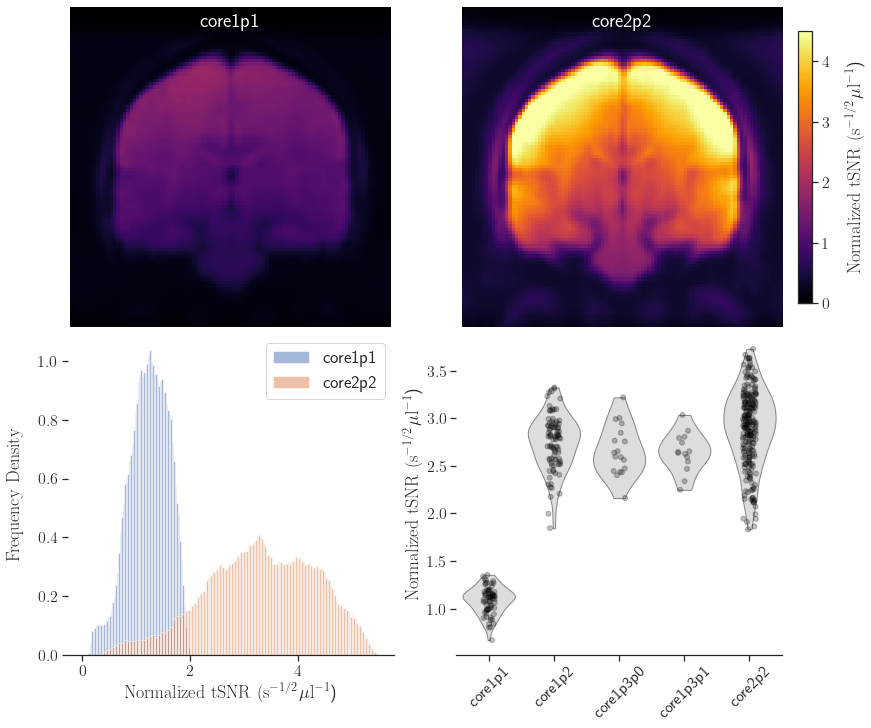

In [3]:
# Limit to core1p1 and core2p2
protocol_names = ['core1p1', 'core2p2']

# MRIQC normalizes to the MNI152 2009c nlin asym 2mm space
# Load the TemplateFlow version of the brain mask to generate histograms
brain_mask = ants.image_read('tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii.gz').numpy().astype(bool)

# Setup subplot grid for two coronal sections and a histogram
hfont = {'fontname':'Helvetica'}
fig, axs = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

# Named axes
ax_hist = axs[1, 0]
ax_violin = axs[1, 1]

for pc, prot in enumerate(protocol_names):
    
    mean_norm_tsnr_fname = f'mean_norm_tSNR_{prot}.nii.gz'
    
    if os.path.isfile(mean_norm_tsnr_fname):        
        mean_norm_tsnr_ai = ants.image_read(mean_norm_tsnr_fname)
    else:
        print(f'* Could not find {mean_norm_tsnr_fname}')
                
    # Extract numpy tSNR image
    mean_norm_tsnr = mean_norm_tsnr_ai.numpy()
    
    # Extract coronal section
    nx, ny, nz = mean_norm_tsnr.shape
    hx, hy, hz = int(nx/2), int(ny/2), int(nz/2)
    tsnr_cor = mean_norm_tsnr[:, hy, :]
    
    # Display coronal section
    cor_im = axs[0, pc].imshow(
        tsnr_cor.transpose(),
        origin='lower',
        vmin=0.0,
        vmax=4.5,
        cmap='inferno'
    )
    
    axs[0, pc].axis('off')
    axs[0, pc].set_title(prot, fontsize=20, x=0.5, y=1.0, pad=-20, color='w')
        
    # Extract mean norm tSNR within MNI brain mask
    tsnr_brain = mean_norm_tsnr[brain_mask]
    
    # Plot overlayed histograms of normalized tSNR
    ax_hist.hist(
        tsnr_brain,
        bins=np.linspace(0, 5.5, 200),
        alpha=0.5,
        density=True
    )
    
# Add coronal section colorbar
cbar = fig.colorbar(cor_im, ax=axs[0, 1], shrink=0.85)
cbar.ax.set_ylabel(r'$\rm{Normalized \ tSNR} \ (s^{-1/2} \mu l^{-1}$)', labelpad=15, fontsize=18)
cbar.ax.tick_params(labelsize=16)

# Add labels and legend to histogram
# Note the Latex rendering
ax_hist.set_xlabel(r'$\rm{Normalized \ tSNR} \ (s^{-1/2} \mu l^{-1}$)', fontsize=18)
ax_hist.set_ylabel(r'$\rm{Frequency \ Density}$', fontsize=18, labelpad=15)
ax_hist.tick_params(axis='x', labelsize=16)
ax_hist.tick_params(axis='y', labelsize=16)
ax_hist.legend(['core1p1', 'core2p2'], fontsize=18)

# Hide histogram top and right spines
ax_hist.spines['right'].set_visible(False)
ax_hist.spines['top'].set_visible(False)
    
# Violin plot subfigure
ordered = sorted(df['Protocol'].unique())

sns.violinplot(
    x='Protocol',
    y='Normalized tSNR',
    data=df,
    cut=0,
    scale='width',
    inner=None,
    linewidth=1,
    color='#DDDDDD',
    saturation=1,
    order=ordered,
    ax=ax_violin)

sns.stripplot(
    x='Protocol',
    y='Normalized tSNR',
    data=df,
    jitter=True,
    linewidth=1,
    color='#050505',
    alpha=0.25,
    order=ordered,
    ax=ax_violin)

sns.despine(left=True)

ax_violin.tick_params(axis='x', labelsize=16, labelrotation=45)
ax_violin.tick_params(axis='y', labelsize=16)
ax_violin.set_xlabel('')
ax_violin.set_ylabel(r'$\rm{Normalized \ tSNR} \ (s^{-1/2} \mu l^{-1}$)', fontsize=18)

# Save figure
plt.savefig('mean_norm_tsnr_figure.png', dpi=300)

plt.show()